In this project, I am going to create a Deep Learning Model to classifies brain tumor scans and see how accurate the model is in classifying brain tumors 

# Importing required libraries

In [3]:
# We will use Tensorflow 
# with keras api to build neural network in the simplest way
# keras runs on Tensorflow backend 

import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer
import numpy as np # for linear algebra and arrays
from matplotlib import pyplot as plt #for plotting

# Importing data and performing data augmentation

In [4]:
# Initialize my batch_size, image_size, channels and epochs

IMAGE_SIZE = 256 # setting all images from the dataset to 256x256 pixels
BATCH_SIZE = 32 # making sure the model trains and validates the data using samples of 32
CHANNELS = 3 # Color pixels of an image is stored in three arrays of values (red, green and blue), known as channels.
EPOCHS = 20 # I will iterate model training and validation 20 times to gain more accuracy 

I have 3 data folders to use in this project, Train, Val and Test.

Train contains the training data/images for teaching our model.

Val contains images used to give an estimate of our model performance after being trained

Test contains images that the model had never seen before that will be used to test the model once it has learned the relationships between the images and their labels/class (type of brain tumor or no brain tumor)

In [5]:
# ImageDataGenerator generates different images with conditions given through iteration of images


# Loading and augmenting train dataset  

train_datagen = ImageDataGenerator(
                                   rescale=1./255,  
                                   rotation_range=20,
                                   horizontal_flip=True,
                                    vertical_flip=True)

train_generator = train_datagen.flow_from_directory('dataset/train',
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='sparse') # 1Dimension numpy array of integer labels


# Loading and augmenting validation dataset   

val_datagen = ImageDataGenerator(
                                   rescale=1./255,
                                   rotation_range=20,
                                   horizontal_flip=True,
                                    vertical_flip=True)

val_generator = train_datagen.flow_from_directory('dataset/val',
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='sparse') # 1Dimension numpy array of labels


# Loading and augmenting test dataset   

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = train_datagen.flow_from_directory('dataset/test',
                                                   target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='sparse') 

Found 2007 images belonging to 4 classes.
Found 285 images belonging to 4 classes.
Found 578 images belonging to 4 classes.


2007 images belonging in the train dataset, 285 images belonging to the validation dataset,
and 578 images belonging to the test dataset


In [7]:
# class names for each label in all datasets
print(train_generator.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


# Exploring the data

Let's look at some of the images in the train dataset. remember, 'glioma_tumor' = 0, 'meningioma_tumor' = 1, 'no_tumor' = 2 and 'pituitary_tumor' = 3}

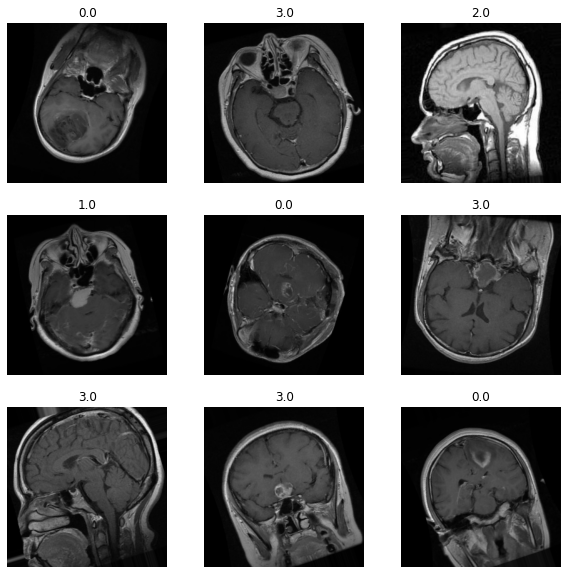

In [8]:
# explore the images by plotting 9 images
# with their respective labels as title

plt.figure(figsize = (10,10))
for image, label in train_generator:
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image[i]) # show image i, converting float to int 
        plt.title(label[i])
        plt.axis('off')
        
    break # have to break the loop or train_generator will keep generating images to plot 

The above pictures are being generated randomly from the dataset. 
Images have differences in them so let's create a Convolutional Neural Network which will create better measures of quantifying and classifying these differences.

# Defining Network Achitecture

I am going to build a 2 dimentional CNN that has 2 Convolution layers. After each convolution, I will add a 2D Pooling layer using max-pooling then flatten the layers to convert the data into a 1-dimensional array for the next layer (fully-connected layer or dense) then finnaly output the image labels/classes (4 labels).

For the CNN parameters, filters specify the dimensionality of the output space (i.e. the number of output filters in the convolution) and kernel_size specify the height and width of the 2D convolution window.

For Max pool (2, 2) will take the max value over a 2x2 pooling window.

Rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero (x,0). It allowing models to learn faster and perform better.

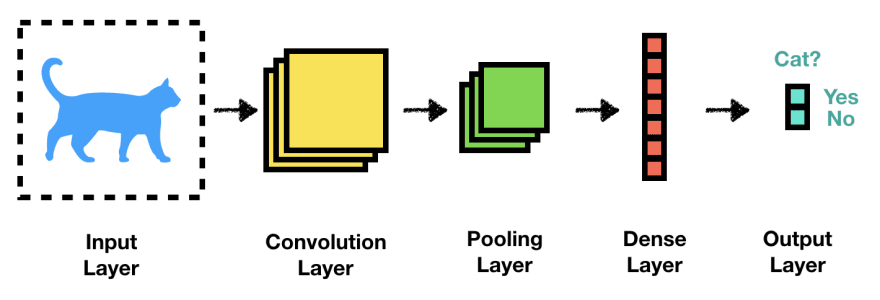

In [36]:
# input shape of the images is 256x256 with color pixels of RGB 
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS) 

# building the network in sequential order
model = Sequential([
    #input images
    InputLayer(input_shape = input_shape),
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size = (2,2)),
    Flatten(),
    # Fully connected layer of the neural network
    Dense(64, activation = 'relu'),
    # Output layer
    #softmax takes the probability of the image to be one of the 4 image output classes
    Dense(4, activation = 'softmax') 
])

In [37]:
# looking at what happened at each stage of the network sequence by looking at the summary 
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 123008)            0         
                                                                 
 dense_16 (Dense)            (None, 64)               

# Compile Model

Compile defines the loss function, the optimizer and the metrics. Using the Adam optimization function which optimizes how fast our model learns the correct classification of the image. SparseCategoricalCrossentropy Loss function computes the crossentropy loss between the labels and predictions. Our labels/class are in integers [0,1,2,3]. Using accuracy metrics to measure the prediction accuracy of the model.

In [38]:
model.compile(
    optimizer = 'adam',
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['accuracy']
)

# Train and Validate Model

In [39]:
history = model.fit(
    train_generator, # training dataset
    epochs = EPOCHS, # number of times I am iterating model training 
    steps_per_epoch = 62, # making sure model does not train pass the number batches present
    validation_data = val_generator, #validation dataset
    validation_steps = 8, # making sure model does not validate pass the number validation batches present
)
# Setting steps_per_epoch and validation_steps because train_generator keeps generating images
# it is equal to number of batches the dataset has, 2007/32 for trainiing

Epoch 1/20
62/62 [==============================] - 100s 2s/step - loss: 1.1502 - accuracy: 0.5175 - val_loss: 0.9733 - val_accuracy: 0.6055
Epoch 2/20
62/62 [==============================] - 96s 2s/step - loss: 0.8904 - accuracy: 0.6177 - val_loss: 0.8781 - val_accuracy: 0.6641
Epoch 3/20
62/62 [==============================] - 109s 2s/step - loss: 0.7919 - accuracy: 0.6638 - val_loss: 0.7887 - val_accuracy: 0.7148
Epoch 4/20
62/62 [==============================] - 99s 2s/step - loss: 0.6687 - accuracy: 0.7185 - val_loss: 0.7790 - val_accuracy: 0.7148
Epoch 5/20
62/62 [==============================] - 93s 1s/step - loss: 0.5819 - accuracy: 0.7630 - val_loss: 0.6492 - val_accuracy: 0.7461
Epoch 6/20
62/62 [==============================] - 6974s 114s/step - loss: 0.5446 - accuracy: 0.7853 - val_loss: 0.6002 - val_accuracy: 0.8203
Epoch 7/20
62/62 [==============================] - 4337s 71s/step - loss: 0.4920 - accuracy: 0.8015 - val_loss: 0.6377 - val_accuracy: 0.7578
Epoch 8/20


Model has an accuracy score of 90  and validation score of 90 which is great.  

In [ ]:
2007/32

In [28]:
285/32

8.90625

# Model Evaluation

In [40]:
score = model.evaluate(test_generator)
score

19/19 [==============================] - 17s 835ms/step - loss: 0.4101 - accuracy: 0.8581


[0.41006308794021606, 0.858131468296051]

Acuracy for test data is 85.8% which is also great

# Visualizing Results

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Let's see the trends of the accuracy score and loss, and the validation score and loss.

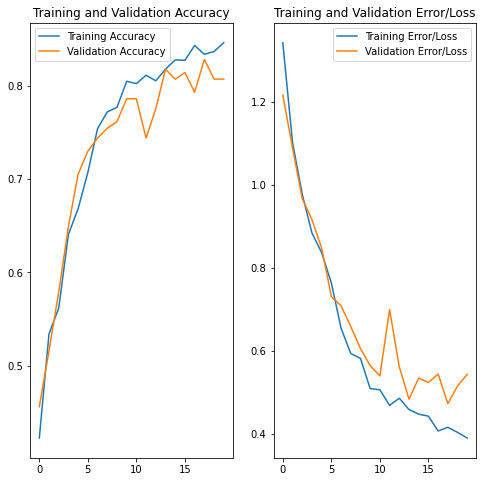

In [25]:
plt.figure(figsize = (8,8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Error/Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Error/Loss')
plt.legend()
plt.title('Training and Validation Error/Loss')

plt.show()

As we can see from the plot above, the model accuracy and validation scores are going up a and losses are going down. It is very possible that we could've had a higher accuracy and lower loss if we used more EPOCHS to train the model.

In [66]:
#Lets make one prediction
prediction = model.predict(test_generator)
prediction[0]

array([7.5062916e-02, 9.1978061e-01, 4.7099477e-04, 4.6853856e-03],
      dtype=float32)

In [67]:
# takes the highest probability of the 4 classes to be the class of the predicted image 
np.argmax([7.5062916e-02, 9.1978061e-01, 4.7099477e-04, 4.6853856e-03]) 

1

first image to predict
actual label: 0.0
Predicted label 0


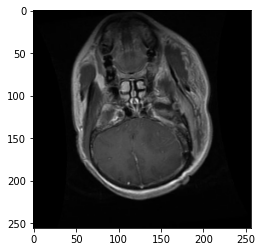

In [73]:
# Lets plot one Prediction

for images, labels in test_generator:
    
    first_image = images[0]
    first_label = labels[0]
    
    print('first image to predict')
    plt.imshow(first_image)
    print('actual label:', first_label)
    
    prediction = model.predict(images)
    print('Predicted label', np.argmax(prediction[0]))
    break    

In [63]:
test_generator.class_indices # reminder of name of labels

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# Save Model

In [ ]:
model.save("./TumorModel.h5") 

# Load model

For future reference

In [ ]:
load_model = tf.keras.models.load_model('./TumorModel')

# Check its architecture
load_model.predict()